In [53]:
!nvidia-smi

Mon May  3 16:18:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  On   | 00000000:04:00.0 Off |                  N/A |
| 23%   42C    P2    58W / 250W |  11084MiB / 11178MiB |     18%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  On   | 00000000:05:00.0 Off |                  N/A |
| 23%   

In [1]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
import os
import time
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

In [5]:
!mkdir data_flow

mkdir: cannot create directory ‘data_flow’: File exists


In [6]:
#Flow

In [7]:
#https://flowmaps.life.bsc.es/flowboard/static/js/mobility.js
province_id_to_name = {'17': 'Girona', '43': 'Tarragona','08': 'Barcelona', '25': 'Lleida'}

In [6]:
#FLOW-Maps end-points

URL_IN_CCAA = "https://flowmaps.life.bsc.es/api/total_incoming_daily_mobility"
URL_OUT_CCAA = "https://flowmaps.life.bsc.es/api/total_outgoing_daily_mobility" 

INCID_CAT = "https://flowmaps.life.bsc.es/api/incidence"
        
URL_RISK_CCAA = "https://flowmaps.life.bsc.es/api/incoming_risk_history/"

In [7]:
#Load data

In [8]:
from datetime import datetime
today = datetime.today().strftime('%Y-%m-%d')
print(today)
payload = {"where":"{\"ev\":\"ES.covid_cpro\",\"start_date\":\"2020-01-01\",\"end_date\":\"" + today + "\"}"}
response = requests.get(INCID_CAT, params=payload, verify = 'flowmaps-life-bsc-es-chain.pem')
print(response.url)

#dfCases["date"] = pd.to_datetime(dfCases["date"])
#dfCases.to_csv("data_flow/cases.csv",index=False)

2021-05-03
https://flowmaps.life.bsc.es/api/incidence?where=%7B%22ev%22%3A%22ES.covid_cpro%22%2C%22start_date%22%3A%222020-01-01%22%2C%22end_date%22%3A%222021-05-03%22%7D


In [12]:
print(len(response.json()["_items"]))

dfCases = []
for i,row in enumerate(response.json()["_items"]):
    date = row.get("_id")
    
    dfDaily = pd.DataFrame(row.get("data"))

    dfRow = pd.DataFrame(np.array([date, 
     dfDaily.loc[dfDaily["id"]=="08"]["new_cases"].values[0], 
     dfDaily.loc[dfDaily["id"]=="17"]["new_cases"].values[0],
     dfDaily.loc[dfDaily["id"]=="43"]["new_cases"].values[0],
     dfDaily.loc[dfDaily["id"]=="25"]["new_cases"].values[0],
    ]).reshape(1,5), columns=["date","new_cases_BCN","new_cases_GI","new_cases_TAR","new_cases_LLE"])
    dfCases.append(dfRow)

dfCases = pd.concat(dfCases)
print(len(dfCases))

475
475


In [13]:
dfCases["date"] = pd.to_datetime(dfCases["date"])
dfCases.sort_values("date",ascending=True, inplace=True)

dfCases.to_csv("data_flow/cases_CAT_" + today + ".csv",index=False)

In [14]:
dfInRisk=[]
for j,val in enumerate(province_id_to_name.keys()):
    payload = {"where":"{\"target\":\"" + val + "\",\"source_layer\":\"cnig_provincias\",\"target_layer\":\"cnig_provincias\",\"ev\":\"ES.covid_cpro\",\"total\":true}"}
    response = requests.get(URL_RISK_CCAA, params=payload, verify = 'flowmaps-life-bsc-es-chain.pem')
    print(response.url)
    df = pd.DataFrame(response.json()["_items"])
    print("CCAA:", val,df.shape)
    
    if len(dfInRisk) == 0:
        dfInRisk = df
        dfInRisk["inrisk_"+val] = dfInRisk["incoming_risk"]
        dfInRisk.date = pd.to_datetime(dfInRisk.date)
        dfInRisk = dfInRisk[["date","inrisk_"+val]]
    else:
        df["inrisk_"+val] = df["incoming_risk"]
        df.date = pd.to_datetime(df.date)
        df = df[["date","inrisk_"+val]]
        dfInRisk = pd.merge(dfInRisk,df,on="date",suffixes=('',''))#,left_index=False,right_index=False) 

#Save
dfInRisk.to_csv("data_flow/inrisk_CAT_"+ today +".csv",index=False)

https://flowmaps.life.bsc.es/api/incoming_risk_history/?where=%7B%22target%22%3A%2217%22%2C%22source_layer%22%3A%22cnig_provincias%22%2C%22target_layer%22%3A%22cnig_provincias%22%2C%22ev%22%3A%22ES.covid_cpro%22%2C%22total%22%3Atrue%7D
CCAA: 17 (398, 2)
https://flowmaps.life.bsc.es/api/incoming_risk_history/?where=%7B%22target%22%3A%2243%22%2C%22source_layer%22%3A%22cnig_provincias%22%2C%22target_layer%22%3A%22cnig_provincias%22%2C%22ev%22%3A%22ES.covid_cpro%22%2C%22total%22%3Atrue%7D
CCAA: 43 (398, 2)
https://flowmaps.life.bsc.es/api/incoming_risk_history/?where=%7B%22target%22%3A%2208%22%2C%22source_layer%22%3A%22cnig_provincias%22%2C%22target_layer%22%3A%22cnig_provincias%22%2C%22ev%22%3A%22ES.covid_cpro%22%2C%22total%22%3Atrue%7D
CCAA: 08 (398, 2)
https://flowmaps.life.bsc.es/api/incoming_risk_history/?where=%7B%22target%22%3A%2225%22%2C%22source_layer%22%3A%22cnig_provincias%22%2C%22target_layer%22%3A%22cnig_provincias%22%2C%22ev%22%3A%22ES.covid_cpro%22%2C%22total%22%3Atrue%7D
CC

In [20]:
#dfInRisk.sort_values("date",ascending=False)

In [ ]:
#LOAD

In [ ]:
#Merge, remove null and na imputation

In [ ]:
#Risk

In [5]:
today = "2021-04-09"

In [6]:
dfInRisk = pd.read_csv("data_flow/inrisk_CAT_" + today + ".csv")

for i,col in enumerate(dfInRisk.columns):
    if i==0:
        dfInRisk[col] = pd.to_datetime(dfInRisk[col])
    else:
        dfInRisk[col] = pd.to_numeric(dfInRisk[col])

dfInRisk.sort_values("date",ascending=True, inplace=True)
dfInRisk["risk_BCN"] = dfInRisk["inrisk_08"]
dfInRisk["risk_GI"] = dfInRisk["inrisk_17"]
dfInRisk["risk_TAR"] = dfInRisk["inrisk_43"]
dfInRisk["risk_LLE"] = dfInRisk["inrisk_25"]
dfInRisk = dfInRisk[["date","risk_BCN","risk_GI","risk_LLE","risk_TAR"]]

print(dfInRisk.shape)
print(dfInRisk.columns)
print(dfInRisk["date"].iloc[-5:])
print(dfInRisk["date"].iloc[0])

(398, 5)
Index(['date', 'risk_BCN', 'risk_GI', 'risk_LLE', 'risk_TAR'], dtype='object')
393   2021-03-15
394   2021-03-16
395   2021-03-17
396   2021-03-18
397   2021-03-19
Name: date, dtype: datetime64[ns]
2020-02-15 00:00:00


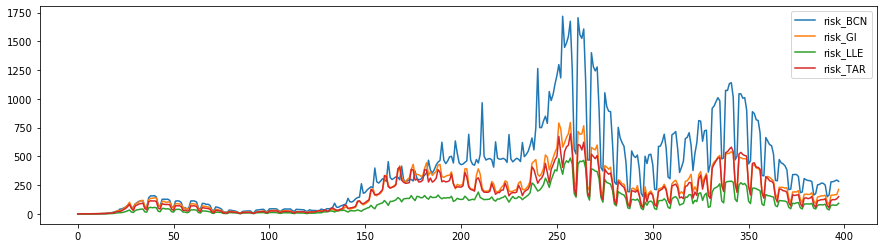

In [7]:
dfInRisk.iloc[:,1:].plot(figsize=(15,4))
plt.show()

In [8]:
# calculate cases by computing the mean of the last 7 days reported cases
cols = dfInRisk.columns
print(cols)
for k in range(1,len(cols)):
    zn = []
    for i in range(dfInRisk.shape[0]):
        acc = 0
        for j in range(7):
            if i-j>=0:
                acc += dfInRisk.iloc[i-j,k]
        zn.append(acc/7)

    dfInRisk[cols[k] + "_7"] = zn
    
    #plot
    #plt.figure(figsize=(10,4))    
    #ax = plt.subplot(1,2,1)
    #dfInRisk[["mean"]].plot(ax=ax)
    #ax = plt.subplot(1,2,2)
    #dfInRisk[["mean_7"]].plot(ax=ax)    
    #plt.show()
    #break
    
dfInRisk = dfInRisk[["date","risk_BCN_7","risk_GI_7","risk_LLE_7","risk_TAR_7"]]
dfInRisk

Index(['date', 'risk_BCN', 'risk_GI', 'risk_LLE', 'risk_TAR'], dtype='object')


,date,risk_BCN_7,risk_GI_7,risk_LLE_7,risk_TAR_7
0,2020-02-15,0.072949,0.151855,0.043482,0.102327
1,2020-02-16,0.143009,0.275563,0.075502,0.181203
2,2020-02-17,0.209083,0.381742,0.108660,0.260290
3,2020-02-18,0.279912,0.493185,0.143284,0.343318
4,2020-02-19,0.354539,0.602402,0.179170,0.428768
...,...,...,...,...,...
393,2021-03-15,233.210782,139.892285,68.357402,106.818405
394,2021-03-16,236.485094,141.624650,68.076668,107.634371
395,2021-03-17,239.198669,142.814572,67.596189,107.492742
396,2021-03-18,243.290157,144.225753,67.145308,108.536820


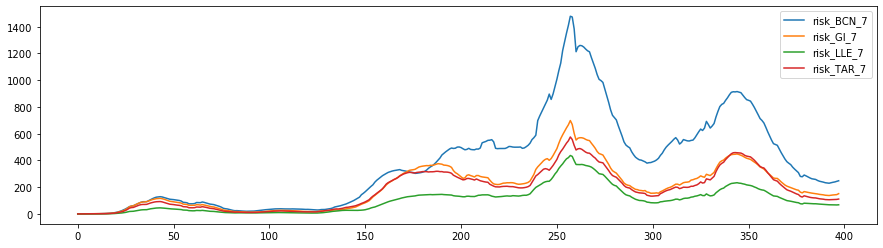

In [9]:
dfInRisk.iloc[:,1:].plot(figsize=(15,4))
plt.show()

In [10]:
#Incidence

In [11]:
dfCases = pd.read_csv("data_flow/cases_CAT_" + today + ".csv")
dfCases["date"] = pd.to_datetime(dfCases["date"])
dfCases.sort_values("date",ascending=True, inplace=True)

#Aggregate
dfCases["new_cases"] = np.nansum(dfCases[['new_cases_BCN', 'new_cases_GI', 
                                          'new_cases_TAR',"new_cases_LLE"]],axis=1)
dfCases = dfCases[["date","new_cases","new_cases_BCN","new_cases_GI","new_cases_TAR","new_cases_LLE"]]
dfCases["total_cases"] = np.cumsum(dfCases["new_cases"].values)
print(dfCases.shape,dfCases.columns)

(464, 7) Index(['date', 'new_cases', 'new_cases_BCN', 'new_cases_GI', 'new_cases_TAR',
       'new_cases_LLE', 'total_cases'],
      dtype='object')


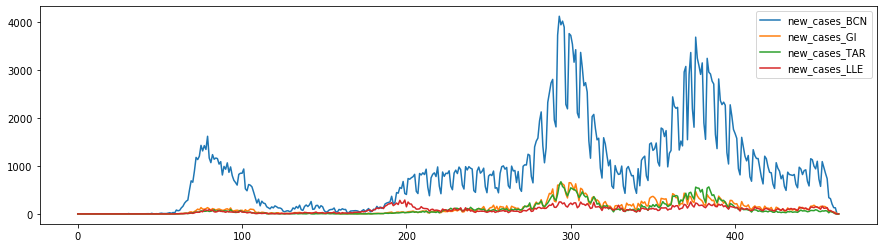

In [12]:
dfCases.iloc[:,2:-1].plot(figsize=(15,4))
plt.show()

In [13]:
cols = dfCases.columns
for k in range(1,len(cols)):
    zn = []
    for i in range(dfCases.shape[0]):
        acc = 0
        for j in range(7):
            if i-j>=0:
                acc += dfCases.iloc[i-j,k]
        zn.append(acc/7)

    dfCases[cols[k] + "_7"] = zn

dfCases

,date,new_cases,new_cases_BCN,new_cases_GI,new_cases_TAR,new_cases_LLE,total_cases,new_cases_7,new_cases_BCN_7,new_cases_GI_7,new_cases_TAR_7,new_cases_LLE_7,total_cases_7
0,2020-01-01,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2020-01-02,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2020-01-03,1,0,0,0,1,1,0.142857,0.000000,0.000000,0.000000,0.142857,0.142857
3,2020-01-04,0,0,0,0,0,1,0.142857,0.000000,0.000000,0.000000,0.142857,0.285714
4,2020-01-05,0,0,0,0,0,1,0.142857,0.000000,0.000000,0.000000,0.142857,0.428571
...,...,...,...,...,...,...,...,...,...,...,...,...,...
459,2021-04-04,339,204,43,41,51,537934,900.714286,641.428571,103.857143,52.571429,102.857143,536045.142857
460,2021-04-05,217,130,29,22,36,538151,721.857143,504.428571,85.571429,46.714286,85.142857,536767.000000
461,2021-04-06,171,127,34,4,6,538322,560.857143,384.857143,67.857143,38.857143,69.285714,537327.857143
462,2021-04-07,0,0,0,0,0,538322,391.857143,264.285714,46.428571,29.142857,52.000000,537719.714286


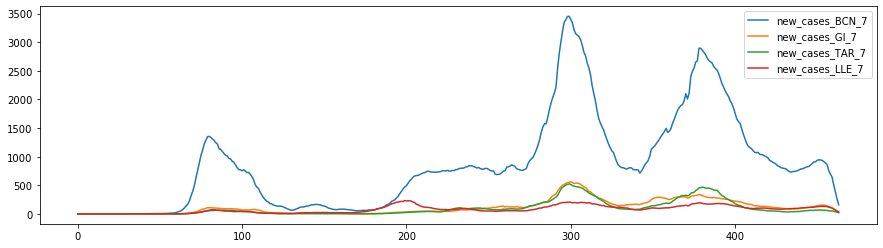

In [14]:
dfCases[["new_cases_BCN_7","new_cases_GI_7","new_cases_TAR_7","new_cases_LLE_7"]].plot(figsize=(15,4))
plt.show()

In [15]:
#Merge cases
dfAll = pd.merge(dfCases[["date","new_cases","total_cases","new_cases_7",
                         "new_cases_GI_7","new_cases_LLE_7","new_cases_BCN_7","new_cases_TAR_7"]],
                 dfInRisk[["date","risk_BCN_7","risk_GI_7","risk_LLE_7","risk_TAR_7"]], 
                 how="left",on="date")
dfAll["date"] = pd.to_datetime(dfAll["date"])

In [16]:
#Remove days without mobility index 
dfAll = dfAll.iloc[121:]

#Remove last day 
dfAll = dfAll.iloc[:-20]#-20


#Na inputation
dfAll.interpolate(method='linear', limit_direction='forward', axis=0, inplace=True, order=2)

print(dfAll.shape)
print(dfAll.isnull().sum())

(323, 12)
date               0
new_cases          0
total_cases        0
new_cases_7        0
new_cases_GI_7     0
new_cases_LLE_7    0
new_cases_BCN_7    0
new_cases_TAR_7    0
risk_BCN_7         0
risk_GI_7          0
risk_LLE_7         0
risk_TAR_7         0
dtype: int64


(310, 70)
Index(['var1(t-7)', 'var2(t-7)', 'var3(t-7)', 'var4(t-7)', 'var5(t-7)',
       'var1(t-6)', 'var2(t-6)', 'var3(t-6)', 'var4(t-6)', 'var5(t-6)',
       'var1(t-5)', 'var2(t-5)', 'var3(t-5)', 'var4(t-5)', 'var5(t-5)',
       'var1(t-4)', 'var2(t-4)', 'var3(t-4)', 'var4(t-4)', 'var5(t-4)',
       'var1(t-3)', 'var2(t-3)', 'var3(t-3)', 'var4(t-3)', 'var5(t-3)',
       'var1(t-2)', 'var2(t-2)', 'var3(t-2)', 'var4(t-2)', 'var5(t-2)',
       'var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var1(t)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)', 'var1(t+1)',
       'var2(t+1)', 'var3(t+1)', 'var4(t+1)', 'var5(t+1)', 'var1(t+2)',
       'var2(t+2)', 'var3(t+2)', 'var4(t+2)', 'var5(t+2)', 'var1(t+3)',
       'var2(t+3)', 'var3(t+3)', 'var4(t+3)', 'var5(t+3)', 'var1(t+4)',
       'var2(t+4)', 'var3(t+4)', 'var4(t+4)', 'var5(t+4)', 'var1(t+5)',
       'var2(t+5)', 'var3(t+5)', 'var4(t+5)', 'var5(t+5)', 'var1(t+6)',
       'var2(t+6)', 'var3(t+6)', 'var4(t+6)', 'var5

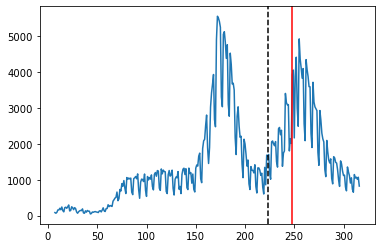

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
307,906.0,1052.0,735.0,650.0,1144.0,1046.0,1070.0
308,1052.0,735.0,650.0,1144.0,1046.0,1070.0,1013.0
309,735.0,650.0,1144.0,1046.0,1070.0,1013.0,1069.0
310,650.0,1144.0,1046.0,1070.0,1013.0,1069.0,822.0
311,1144.0,1046.0,1070.0,1013.0,1069.0,822.0,708.0
312,1046.0,1070.0,1013.0,1069.0,822.0,708.0,1298.0
313,1070.0,1013.0,1069.0,822.0,708.0,1298.0,1270.0
314,1013.0,1069.0,822.0,708.0,1298.0,1270.0,1135.0
315,1069.0,822.0,708.0,1298.0,1270.0,1135.0,1183.0
316,822.0,708.0,1298.0,1270.0,1135.0,1183.0,1216.0


In [17]:
#Convert data to format (rows,timepoints,features)
cols = [
         'new_cases',
         #'new_cases_7',
         #'new_cases_GI_7',
         #'new_cases_TAR_7',
         #'new_cases_BCN_7',
         #'new_cases_LLE_7',    
         'risk_BCN_7',
         'risk_GI_7',
         'risk_LLE_7',
         'risk_TAR_7'
]
res = series_to_supervised(dfAll.loc[:,cols].values,7,7)
print(res.shape)
print(res.columns)

THR_VAL = int(res.shape[0]*0.2)
THR = int(res.shape[0]-THR_VAL)
print("TR:",THR,"TS:",THR_VAL)

plt.plot(res["var1(t)"])
plt.axvline(THR,c="r")
plt.axvline(int(THR-(THR*0.10)),c="black", ls="--")
plt.show()
res.iloc[-10:,[(7*len(cols))+(i*len(cols)) for i in range(7)]]

In [18]:
#Patition train/test
train_X = res.iloc[:THR,:7*len(cols)].values.reshape(-1,7,len(cols))
train_y = res.iloc[:THR,[(7*len(cols))+(len(cols)*i) for i in range(7)]].values.reshape(-1,7)
test_X = res.iloc[THR:,:(7*len(cols))].values.reshape(-1,7,len(cols))
test_y = res.iloc[THR:,[(7*len(cols))+(len(cols)*i) for i in range(7)]].values.reshape(-1,7)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(248, 7, 5) (248, 7) (62, 7, 5) (62, 7)


In [19]:
display(test_X[-1,:,0])
display(test_y[-1])

array([ 735.,  650., 1144., 1046., 1070., 1013., 1069.])

array([ 822.,  708., 1298., 1270., 1135., 1183., 1216.])

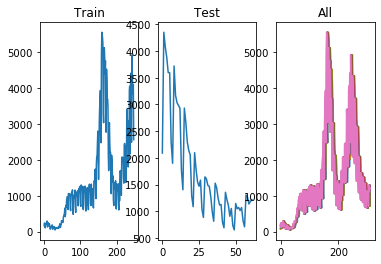

In [20]:
ax=plt.subplot(1,3,1)
ax.plot(range(len(train_y)),train_y[:,-1])
ax.set_title("Train")
ax=plt.subplot(1,3,2)
ax.plot(range(len(test_y)),test_y[:,-1])
ax.set_title("Test")
ax=plt.subplot(1,3,3)
ax.plot(range(len(test_y)+len(train_y)),np.vstack((train_y,test_y)))
ax.set_title("All")
plt.show()

In [21]:
fname = "best_model_flow_provs_CAT_21ahead_1_04022021_fixed.1.mov"

In [22]:
from pickle import dump

# normalize features
scalers_X = []
for i in range(train_X.shape[-1]):

    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_X[:,:,i] = scaler.fit_transform(train_X[:,:,i])
    test_X[:,:,i] = scaler.transform(test_X[:,:,i])
    scalers_X.append(scaler)
    dump(scaler, open("models/"+ fname + "_scaler_tr_X_" + str(i)+'.pkl', 'wb'))
    
scaler_y = MinMaxScaler(feature_range=(0, 1))
train_y = scaler_y.fit_transform(train_y.reshape(-1,7))
test_y = scaler_y.transform(test_y.reshape(-1,7))
dump(scaler_y, open("models/"+ fname + "_scaler_tr_Y.pkl", 'wb'))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(248, 7, 5) (248, 7) (62, 7, 5) (62, 7)


In [23]:
scaler_y.inverse_transform(train_y)[:5]

array([[ 82.,  64.,  89., 156., 155., 203., 162.],
       [ 64.,  89., 156., 155., 203., 162., 238.],
       [ 89., 156., 155., 203., 162., 238., 137.],
       [156., 155., 203., 162., 238., 137., 103.],
       [155., 203., 162., 238., 137., 103., 220.]])

In [24]:
#Model

In [25]:
# fit network
bs=4
history=[]
min_tr = []
min_val = []
for i in range(5):
    print("Model:",i)
    model = keras.Sequential()
    model.add(keras.layers.LSTM(50, activation="relu",
                                input_shape=(train_X.shape[1], train_X.shape[2]),recurrent_dropout=0.3))
                                #return_sequences=True))                            
    #model.add(keras.layers.LSTM(50))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(7))
    opt = keras.optimizers.Adam(learning_rate=0.001) 
    model.compile(loss='mean_squared_error', optimizer=opt,metrics=["mae"])
    
    # design callbacks
    es = keras.callbacks.EarlyStopping(monitor='val_mae', 
                                       verbose=1, patience=50)
    mc = keras.callbacks.ModelCheckpoint("models/"+ fname + "_" + str(i) +'.h5', 
                                         monitor='val_mae', 
                                         verbose=0, save_best_only=True)

    history.append(model.fit(train_X, train_y, epochs=500, batch_size=bs, 
                        callbacks=[es,mc],
                        validation_split=0.10, verbose=0, shuffle=False))
    
    ix = np.argmin(history[-1].history.get('val_mae'))
    min_val.append(history[-1].history.get('val_mae')[ix])
    min_tr.append(history[-1].history.get('mae')[ix])
    print("MAE:",min_tr[-1], min_val[-1],ix)

Model: 0
Epoch 00140: early stopping
MAE: 0.05902712792158127 0.11885068565607071 89
Model: 1
Epoch 00325: early stopping
MAE: 0.051454585045576096 0.10433429479598999 274
Model: 2
Epoch 00189: early stopping
MAE: 0.06015024334192276 0.11893720924854279 138
Model: 3
Epoch 00405: early stopping
MAE: 0.056420471519231796 0.1122056171298027 354
Model: 4
MAE: 0.052201125770807266 0.10545927286148071 473


In [26]:
print("\nMIN TR:",np.mean(min_tr),np.std(min_tr))
print("MIN VAL:",np.mean(min_val),np.std(min_val))


MIN TR: 0.05585071071982384 0.0035084362790429526
MIN VAL: 0.11195741593837738 0.006271110352788512


In [44]:
#Test

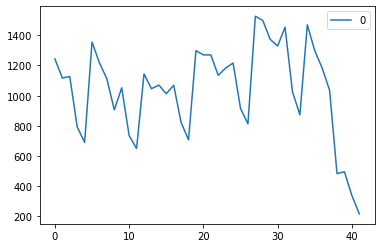

In [78]:
ts_y_real = scaler_y.inverse_transform(test_y)  
plt.plot(np.concatenate((ts_y_real[0],ts_y_real[-1]),axis=0),label="0")
plt.legend()

Classifier: 0

Loading... best_model_flow_provs_CAT_21ahead_1_04022021_fixed.1.no_regs


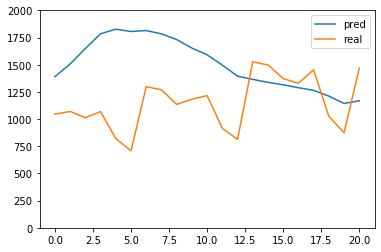

MAE daily: [233.89 332.36 439.67 796.12 372.13]
MAPE daily: [0.27 0.36 0.44 1.16 0.35]
R2 daily: [ 0.01 -0.32 -0.33  0.62 -0.68]
Classifier: 1

Loading... best_model_flow_provs_CAT_21ahead_1_04022021_fixed.1.no_regs


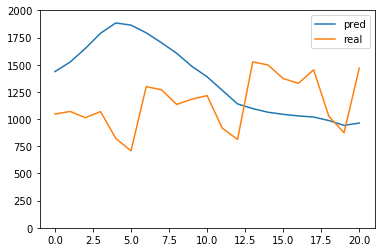

MAE daily: [245.82 326.04 452.9  441.06 326.31]
MAPE daily: [0.27 0.34 0.44 0.67 0.31]
R2 daily: [ 0.04 -0.36 -0.42  0.5  -0.78]
Classifier: 2

Loading... best_model_flow_provs_CAT_21ahead_1_04022021_fixed.1.no_regs


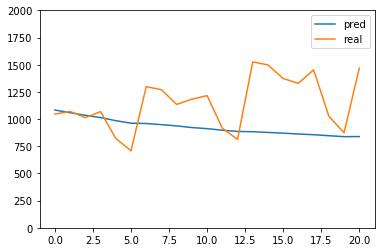

MAE daily: [192.01 237.84 272.86 322.71 155.06]
MAPE daily: [0.2  0.21 0.22 0.46 0.14]
R2 daily: [ 0.11 -0.06 -0.36  0.45 -0.83]
Classifier: 3

Loading... best_model_flow_provs_CAT_21ahead_1_04022021_fixed.1.no_regs


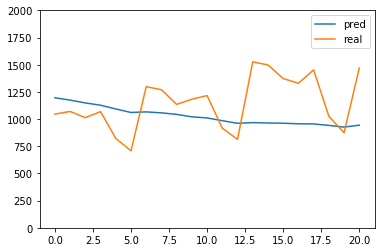

MAE daily: [198.81 202.12 248.98 332.93 138.2 ]
MAPE daily: [0.2  0.19 0.21 0.48 0.12]
R2 daily: [ 0.09 -0.15 -0.33  0.46 -0.83]
Classifier: 4

Loading... best_model_flow_provs_CAT_21ahead_1_04022021_fixed.1.no_regs


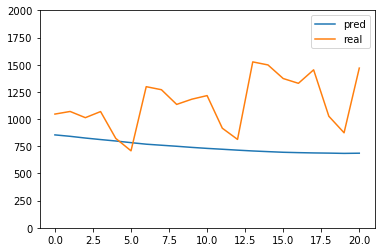

MAE daily: [215.03 240.42 410.37 489.44 214.92]
MAPE daily: [0.21 0.22 0.33 0.48 0.19]
R2 daily: [ 0.09 -0.21 -0.42  0.44 -0.83]


In [79]:
err_mae_all = []
err_mape_all = []
err_r2_all = []
for cc in range(5):
    
    err_mae = []
    err_perc = []
    err_r2 = []
    print("Classifier:", cc)
    print("\nLoading...", fname)
    model = tf.keras.models.load_model("models/"+ fname + "_" + str(cc) +'.h5')
    
    ts = model.predict(test_X)
    ts_y_pred = scaler_y.inverse_transform(ts)
    ts_y_real = scaler_y.inverse_transform(test_y)    
    
    for i in [0,6,13,20]:
        y_pred = ts_y_pred[:,i]
        y_real = ts_y_real[:,i]

        err_diff_m = np.mean(np.abs(y_real - y_pred))
        err_diff_s = np.std(np.abs(y_real - y_pred))       
        err_mae.extend([err_diff_m])
        
        err_diff_m = np.mean(np.abs(y_real - y_pred)/y_real)
        err_diff_s = np.mean(np.abs(y_real - y_pred)/y_real)
        err_perc.extend([err_diff_m])
        err_r2.extend([np.corrcoef(y_real,y_pred)[0][1]])
        
        if i == 13:
            ax = plt.subplot(1,1,1)
            ax.plot(y_pred,label="pred")
            ax.plot(y_real,label="real")
            plt.legend()
            plt.ylim(0,2000)
            plt.show() 

    y_pred = ts_y_pred.mean(axis=1)
    y_real = ts_y_real.mean(axis=1)

    err_diff_m = np.mean(np.abs(y_real - y_pred))
    err_diff_s = np.std(np.abs(y_real - y_pred))       
    err_mae.extend([err_diff_m])

    err_diff_m = np.mean(np.abs(y_real - y_pred)/y_real)
    err_diff_s = np.mean(np.abs(y_real - y_pred)/y_real)
    err_r2.extend([np.corrcoef(y_real,y_pred)[0][1]])
    err_perc.extend([err_diff_m])

    """
    ax = plt.subplot(1,1,1)
    ax.plot(y_pred,label="pred")
    ax.plot(y_real,label="real")
    plt.legend()
    plt.ylim(0,2000)
    plt.show()
    """
    
    err_mae_all.append(err_mae)
    err_mape_all.append(err_perc)
    err_r2_all.append(err_r2)
    
    print("MAE daily:", np.round(err_mae_all[-1],2))
    print("MAPE daily:", np.round(err_mape_all[-1],2))
    print("R2 daily:", np.round(err_r2_all[-1],2))

In [80]:
err_mae_all = np.array(err_mae_all)
err_mape_all = np.array(err_mape_all)
err_r2_all = np.array(err_r2_all)
print(err_mae_all.shape)
df = []
print("MAE:",np.round(err_mae_all.mean(axis=0),2), np.round(err_mae_all.std(axis=0),2))
print("MAPE:",np.round(err_mape_all.mean(axis=0),2), np.round(err_mape_all.std(axis=0),2))
print("R2:",np.round(err_r2_all.mean(axis=0),2), np.round(err_r2_all.std(axis=0),2))

(5, 5)
MAE: [217.11 267.76 364.96 476.45 241.32] [ 20.37  52.    86.38 171.95  92.85]
MAPE: [0.23 0.27 0.33 0.65 0.22] [0.04 0.07 0.1  0.27 0.09]
R2: [ 0.07 -0.22 -0.37  0.49 -0.79] [0.04 0.11 0.04 0.07 0.06]
